In [2]:
import mne
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter
from matplotlib.colors import ListedColormap
from scipy import stats
from scipy.signal import welch
import seaborn as sns
import gc

In [3]:

folder_path = 'sleep-edf-database-expanded-1.0.0'

print(f"📂 Scanning folder: {folder_path}...\n")

if not os.path.exists(folder_path):
    print("❌ Error: Folder not found! Check the name.")
else:
    all_files = sorted(glob.glob(os.path.join(folder_path, '**', '*.edf'), recursive=True))

    psg_files = [f for f in all_files if 'PSG' in f]
    hypno_files = [f for f in all_files if 'Hypnogram' in f]

    print(f"📊 Summary:")
    print(f"   Total Files Found: {len(all_files)}")
    print(f"   -> PSG Files (Data):   {len(psg_files)}")
    print(f"   -> Hypnogram Files (Labels): {len(hypno_files)}")
    
    if len(psg_files) == len(hypno_files):
        print("\n✅ Perfect Match! You have a label file for every recording.")
    else:
        print(f"\n⚠️ Mismatch! You have {len(psg_files)} recordings but only {len(hypno_files)} label files.")

    print("\n📝 First 5 Files found:")
    for f in all_files[:5]:
        print(f"   - {os.path.basename(f)}")

📂 Scanning folder: sleep-edf-database-expanded-1.0.0...

📊 Summary:
   Total Files Found: 394
   -> PSG Files (Data):   197
   -> Hypnogram Files (Labels): 197

✅ Perfect Match! You have a label file for every recording.

📝 First 5 Files found:
   - SC4001E0-PSG.edf
   - SC4001EC-Hypnogram.edf
   - SC4002E0-PSG.edf
   - SC4002EC-Hypnogram.edf
   - SC4011E0-PSG.edf


📂 Loading Subject: SC4001E0-PSG.edf...


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2409350744.py:23: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2409350744.py:23: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2409350744.py:23: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)



📋 RECORDING DETAILS
🔹 Channel Names: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']
🔹 Sampling Rate: 100.0 Hz
🔹 Duration:      22.08 hours
🔹 Date recorded: 1989-04-24 16:13:00+00:00

🔹 Sleep Stages Found (Labels):
{'Sleep stage 1': 1, 'Sleep stage 2': 2, 'Sleep stage 3': 3, 'Sleep stage 4': 4, 'Sleep stage ?': 5, 'Sleep stage R': 6, 'Sleep stage W': 7}


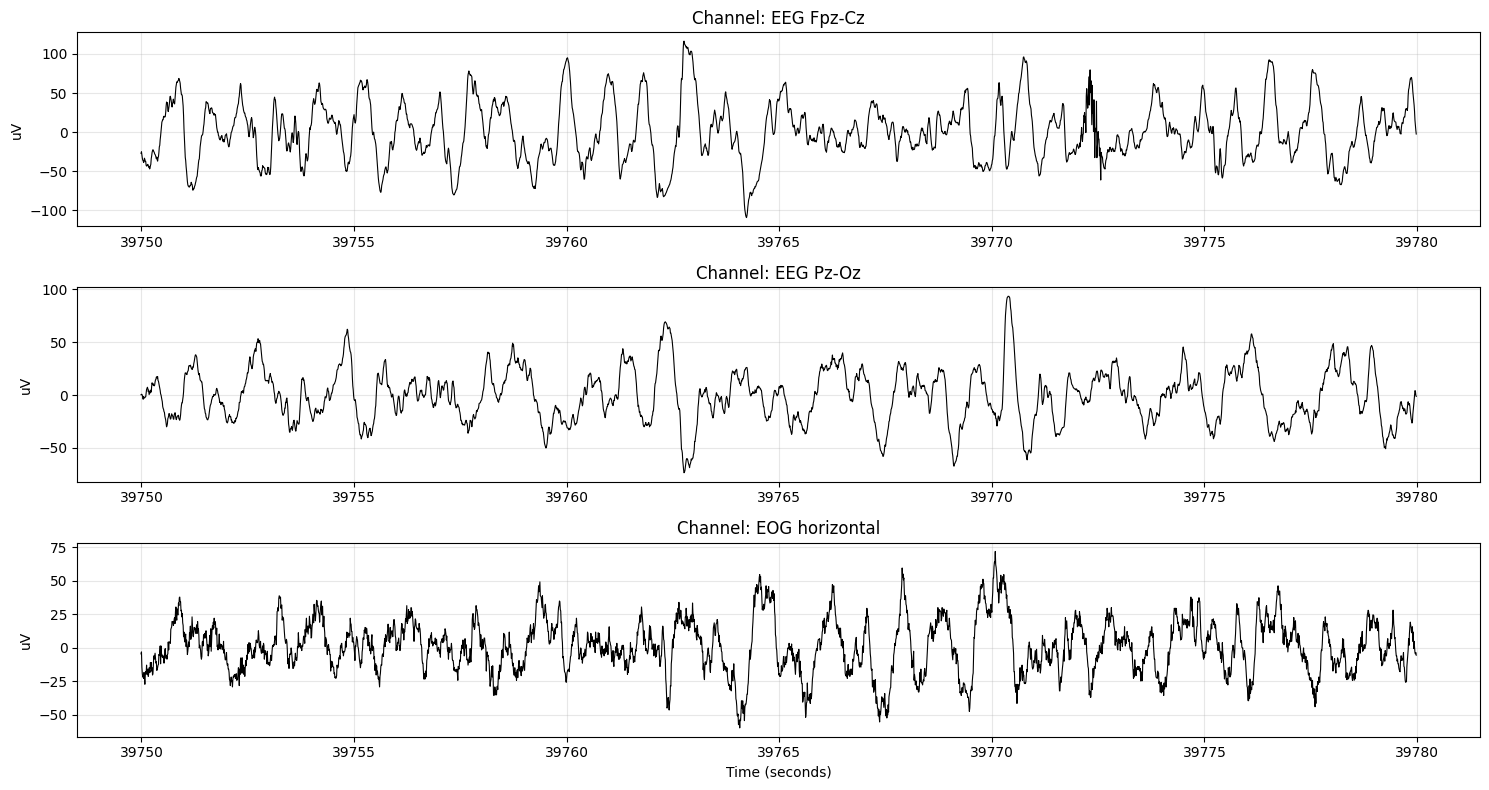


✅ This is what 30 seconds of raw sleep data looks like!


In [5]:
# ==========================================
# 1. Locate the first recording in the dataset
# ==========================================
RAW_FOLDER = 'sleep-edf-database-expanded-1.0.0'

# Search recursively for PSG (signal) and Hypnogram (sleep stage labels) files
psg_files = sorted(glob.glob(os.path.join(RAW_FOLDER, '**', '*PSG.edf'), recursive=True))
hypno_files = sorted(glob.glob(os.path.join(RAW_FOLDER, '**', '*Hypnogram.edf'), recursive=True))

if not psg_files:
    print("❌ Error: No files found in the folder.")
else:
    # Select the first subject as an example
    psg_path = psg_files[0]
    hypno_path = hypno_files[0]
    
    print(f"📂 Loading Subject: {os.path.basename(psg_path)}...")

    # ==========================================
    # 2. Load raw signals and annotations
    # ==========================================
    # Load physiological signals (EEG, EOG, EMG, etc.)
    raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
    
    # Load sleep stage annotations (hypnogram)
    annot = mne.read_annotations(hypno_path)
    
    # Attach annotations to the raw signal object
    raw.set_annotations(annot, emit_warning=False)

    # ==========================================
    # 3. Technical summary of the recording
    # ==========================================
    print("\n" + "="*40)
    print("📋 RECORDING DETAILS")
    print("="*40)
    
    # Channel names (EEG, EOG, etc.)
    print(f"🔹 Channel Names: {raw.ch_names}")
    
    # Sampling frequency in Hz
    print(f"🔹 Sampling Rate: {raw.info['sfreq']} Hz")
    
    # Total recording duration (converted to hours)
    print(f"🔹 Duration:      {raw.times[-1] / 3600:.2f} hours")
    
    # Recording date (if available in metadata)
    print(f"🔹 Date recorded: {raw.info['meas_date']}")
    
    # Extract events (sleep stages) from annotations
    events, event_id = mne.events_from_annotations(raw, verbose=False)
    
    print("\n🔹 Sleep Stages Found (Labels):")
    print(event_id)

    # ==========================================
    # 4. Visualization – Plot 30 seconds of data
    # ==========================================
    # We will visualize a 30-second segment from the middle of the recording
    # to avoid potential noise/artifacts at the beginning.

    # Select relevant channels for visualization
    picks = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal']
    
    # Keep only channels that actually exist in the file
    final_picks = [c for c in picks if c in raw.ch_names]

    # Define the middle of the recording
    start_time = raw.times[-1] / 2  # Middle of the recording (in seconds)
    duration = 30  # Segment length in seconds
    
    # Extract data segment
    data, times = raw.get_data(
        picks=final_picks,
        start=int(start_time * raw.info['sfreq']),
        stop=int((start_time + duration) * raw.info['sfreq']),
        return_times=True
    )

    # Create figure
    plt.figure(figsize=(15, 8))
    
    # Plot each channel separately
    for i, channel_name in enumerate(final_picks):
        plt.subplot(len(final_picks), 1, i + 1)
        
        # Convert signal from Volts to microvolts for better readability
        plt.plot(times, data[i] * 1e6, color='black', lw=0.8)
        
        plt.title(f"Channel: {channel_name}")
        plt.ylabel("uV")
        plt.grid(True, alpha=0.3)
        
        # Add x-axis label only to the last subplot
        if i == len(final_picks) - 1:
            plt.xlabel("Time (seconds)")

    plt.tight_layout()
    plt.show()

    print("\n✅ This is what 30 seconds of raw sleep data looks like!")


In [6]:
# ==========================================
# 1. Define dataset paths and locate files
# ==========================================

RAW_FOLDER = 'sleep-edf-database-expanded-1.0.0'

# Recursively search for PSG signal files and Hypnogram annotation files
psg_files = sorted(glob.glob(os.path.join(RAW_FOLDER, '**', '*PSG.edf'), recursive=True))
hypno_files = sorted(glob.glob(os.path.join(RAW_FOLDER, '**', '*Hypnogram.edf'), recursive=True))

stats_list = []

print(f"📊 Analyzing {len(psg_files)} subjects. Please wait...")

# ==========================================
# 2. Iterate over all subjects
# ==========================================

for psg_path, hypno_path in zip(psg_files, hypno_files):
    try:
        # Extract subject ID from filename (first 6 characters)
        subject_id = os.path.basename(psg_path)[:6]
        
        # ------------------------------------------
        # Load annotations ONLY (fast operation)
        # We do NOT load raw EEG signals to save time and memory
        # ------------------------------------------
        annot = mne.read_annotations(hypno_path)
        
        # Retrieve duration (in seconds) and stage descriptions
        durations = annot.duration
        descriptions = annot.description
        
        # Compute total recording time in seconds
        total_seconds = sum(durations)
        
        # Initialize dictionary to store per-subject statistics
        subject_stats = {
            'Subject': subject_id,
            'Total_Hours': round(total_seconds / 3600, 2),  # Convert to hours
            'W_min': 0,
            'N1_min': 0,
            'N2_min': 0,
            'N3_min': 0,
            'REM_min': 0
        }
        
        # ------------------------------------------
        # Aggregate minutes spent in each sleep stage
        # ------------------------------------------
        for dur, desc in zip(durations, descriptions):
            minutes = dur / 60  # Convert seconds to minutes
            
            if 'W' in desc:
                subject_stats['W_min'] += minutes
            elif '1' in desc:
                subject_stats['N1_min'] += minutes
            elif '2' in desc:
                subject_stats['N2_min'] += minutes
            elif '3' in desc or '4' in desc:  # Combine N3 and N4 as deep sleep
                subject_stats['N3_min'] += minutes
            elif 'R' in desc:
                subject_stats['REM_min'] += minutes
            
        # Round stage durations to one decimal place
        for k in ['W_min', 'N1_min', 'N2_min', 'N3_min', 'REM_min']:
            subject_stats[k] = round(subject_stats[k], 1)
            
        stats_list.append(subject_stats)
        
    except Exception as e:
        print(f"Error analyzing {subject_id}: {e}")

# ==========================================
# 3. Create final DataFrame
# ==========================================

df = pd.DataFrame(stats_list)

# ==========================================
# 4. Compute overall sleep stage percentages
# ==========================================

# Total minutes across all subjects and all stages
total_mins = df[['W_min', 'N1_min', 'N2_min', 'N3_min', 'REM_min']].sum().sum()

# Compute percentage distribution per stage
avg_percentages = (
    df[['W_min', 'N1_min', 'N2_min', 'N3_min', 'REM_min']]
    .sum() / total_mins * 100
).round(1)

# ==========================================
# 5. Print dataset summary
# ==========================================

print("\n" + "="*50)
print("📝 DATASET SUMMARY (AVERAGE PER SUBJECT)")
print("="*50)
print(f"Total Subjects Analyzed: {len(df)}")
print(f"Average Recording Length: {df['Total_Hours'].mean():.1f} hours")

print("\nDistribution of Sleep Stages (Overall %):")
for stage, pct in avg_percentages.items():
    print(f"   {stage.split('_')[0]}: {pct}%")

print("\n" + "="*50)
print("📄 FIRST 10 SUBJECTS TABLE:")
print(df.head(10).to_string(index=False))

# ==========================================
# Optional: Save results to CSV
# ==========================================

# df.to_csv('sleep_statistics.csv', index=False)


📊 Analyzing 197 subjects. Please wait...

📝 DATASET SUMMARY (AVERAGE PER SUBJECT)
Total Subjects Analyzed: 197
Average Recording Length: 20.4 hours

Distribution of Sleep Stages (Overall %):
   W: 63.4%
   N1: 5.5%
   N2: 19.4%
   N3: 4.2%
   REM: 7.5%

📄 FIRST 10 SUBJECTS TABLE:
Subject  Total_Hours  W_min  N1_min  N2_min  N3_min  REM_min
 SC4001         24.0  998.5    29.0   125.0   110.0     62.5
 SC4002         24.0  942.5    29.5   186.5   148.5    107.5
 SC4011         24.0  928.0    54.5   281.0    52.5     85.0
 SC4012         24.0  912.0    46.0   330.0    48.0     88.0
 SC4021         24.0  953.5    47.0   272.5    47.5     81.5
 SC4022         24.0  935.5    92.0   201.0    59.5     89.5
 SC4031         24.0 1004.0    30.5   242.5    28.5    104.5
 SC4032         24.0  978.5    22.5   200.0    65.5     99.5
 SC4041         24.0  767.0    83.0   310.0    26.5     98.0
 SC4042         24.0  886.5    68.5   257.0    47.0    135.0


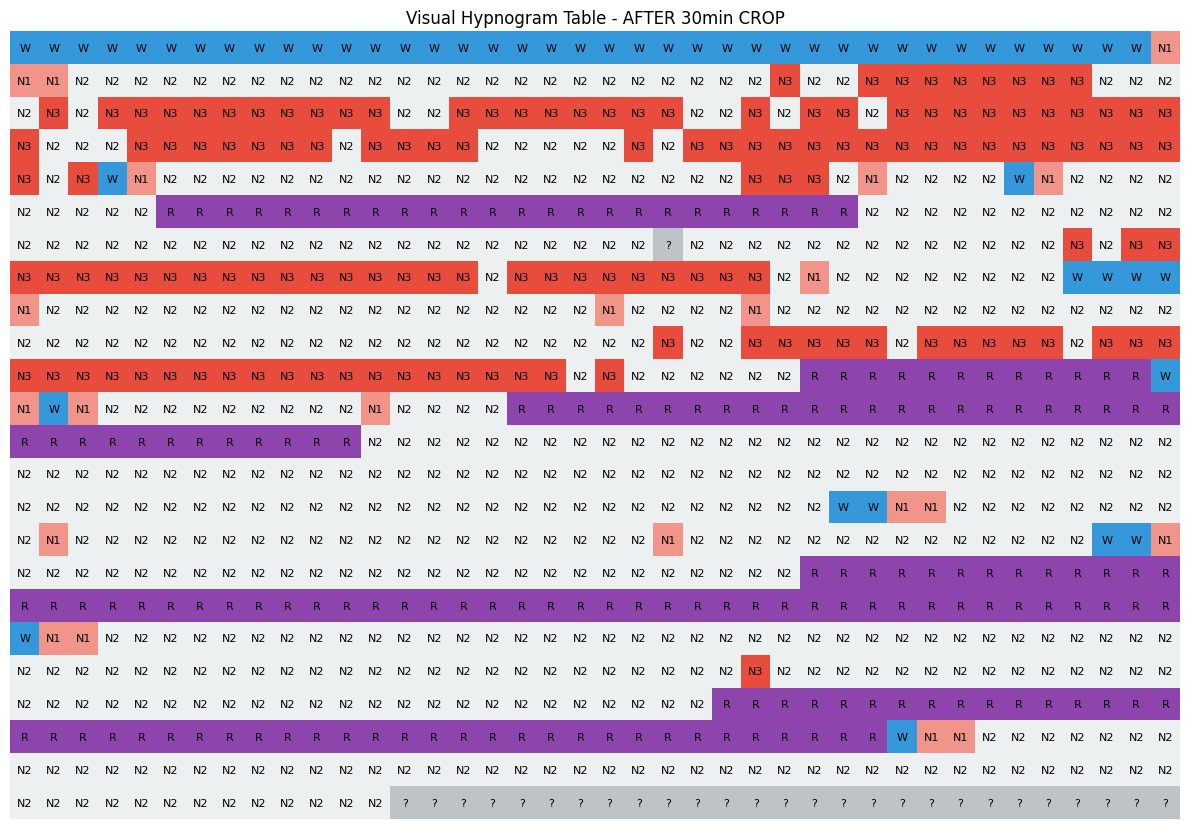

In [7]:
# ==========================================
# 1. Define mapping dictionaries
# ==========================================

# Map sleep stage descriptions to numeric labels
# (Used later to build a numerical hypnogram representation)
mapping = {
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,  # Merge N3 and N4 into Deep Sleep (N3)
    'Sleep stage R': 4,
    'Sleep stage ?': 5   # Unknown / Movement / Undefined
}

# Reverse mapping for visualization (numeric → label)
stage_names = {
    0: 'W',
    1: 'N1',
    2: 'N2',
    3: 'N3',
    4: 'R',
    5: '?'
}

# ==========================================
# 2. Smart cropping function (removes excess wake)
# ==========================================

def get_cropped_annotations(annot):
    """
    Crops the recording to remove excessive wake periods 
    at the beginning and end of the night.
    
    Keeps:
    - 30 minutes before the first non-wake stage
    - 30 minutes after the last non-wake stage
    """
    
    # Find indices that correspond to real sleep stages (not Wake or Unknown)
    valid_idx = [
        i for i, d in enumerate(annot.description)
        if any(s in d for s in ['1', '2', '3', '4', 'R'])
    ]
    
    # If no sleep stages are found, return full recording
    if not valid_idx:
        return 0, annot.onset[-1]
    
    # Start 30 minutes before first sleep stage
    t_start = max(0, annot.onset[valid_idx[0]] - 30 * 60)
    
    # End 30 minutes after last sleep stage
    t_end = min(annot.onset[-1], annot.onset[valid_idx[-1]] + 30 * 60)
    
    return t_start, t_end


# ==========================================
# 3. Apply cropping to annotations
# ==========================================

# Compute cropped time window
t_start, t_end = get_cropped_annotations(annot)

# Keep only annotations within cropped time range
mask = (annot.onset >= t_start) & (annot.onset <= t_end)

# Adjust onsets so that cropped timeline starts at 0
cropped_onsets = annot.onset[mask] - t_start
cropped_descriptions = annot.description[mask]
cropped_durations = annot.duration[mask]


# ==========================================
# 4. Build epoch-level hypnogram (30-second epochs)
# ==========================================

# Compute total cropped duration
total_duration_cropped = t_end - t_start

# Number of 30-second epochs
n_epochs_cropped = int(total_duration_cropped / 30)

# Initialize full-night hypnogram array
full_night_cropped = np.zeros(n_epochs_cropped)

# Fill hypnogram with numeric sleep stage labels
for onset, duration, desc in zip(cropped_onsets, cropped_durations, cropped_descriptions):
    
    # Convert onset time to epoch index
    start_epoch = int(onset / 30)
    
    # Convert duration to number of epochs
    duration_epochs = int(duration / 30)
    
    # Convert textual label to numeric value
    stage_val = mapping.get(desc, 5)
    
    # Prevent overflow beyond total number of epochs
    end_epoch = min(start_epoch + duration_epochs, n_epochs_cropped)
    
    # Assign stage value to relevant epoch range
    full_night_cropped[start_epoch:end_epoch] = stage_val


# ==========================================
# 5. Visualize as table-like hypnogram
# ==========================================

# Define table shape (40 epochs per row)
cols = 40
rows = int(np.ceil(len(full_night_cropped) / cols))

# Pad array if needed to complete last row
padded_cropped = np.pad(
    full_night_cropped,
    (0, rows * cols - len(full_night_cropped)),
    constant_values=5  # Fill missing values with "Unknown"
)

# Reshape into matrix form
matrix_cropped = padded_cropped.reshape(rows, cols)

# Custom colormap:
# Blue = Wake, Red tones = Sleep, Purple = REM, Gray = Unknown
custom_cmap = ListedColormap([
    '#3498db',  # Wake
    '#f1948a',  # N1
    '#ecf0f1',  # N2
    '#e74c3c',  # N3
    '#8e44ad',  # REM
    '#bdc3c7'   # Unknown
])

plt.figure(figsize=(12, rows * 0.35))
plt.imshow(matrix_cropped, cmap=custom_cmap, aspect='auto')

# Overlay stage labels inside each cell
for i in range(rows):
    for j in range(cols):
        val = int(matrix_cropped[i, j])
        plt.text(
            j,
            i,
            stage_names.get(val, '?'),
            ha='center',
            va='center',
            fontsize=8
        )

plt.title("Visual Hypnogram Table - AFTER 30min CROP")
plt.axis('off')
plt.tight_layout()
plt.show()


In [8]:
# ==========================================
# 1. Define paths and parameters
# ==========================================

RAW_FOLDER = 'sleep-edf-database-expanded-1.0.0'

# Channels used for the model (EEG + EOG)
CHANNELS = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal']

# Target sampling frequency (Hz)
SFREQ = 100 

# Locate PSG and Hypnogram files
psg_files = sorted(glob.glob(os.path.join(RAW_FOLDER, '**', '*PSG.edf'), recursive=True))
hypno_files = sorted(glob.glob(os.path.join(RAW_FOLDER, '**', '*Hypnogram.edf'), recursive=True))

# Map textual sleep stages to numeric labels
stage_mapping = {
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,  # Merge N3 and N4 (Deep Sleep)
    'Sleep stage R': 4
}

home_x, home_y = [], []

print(f"🚀 Starting process for {len(psg_files)} files...")

# ==========================================
# 2. Preprocessing: load, crop wake, normalize
# ==========================================

for psg_p, hypno_p in zip(psg_files, hypno_files):

    # Extract subject ID
    subject_id = os.path.basename(psg_p)[:6]
    
    # Process only home recordings (SC subjects)
    if 'SC' not in subject_id:
        continue 
    
    try:
        # Load raw EEG signals
        raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
        
        # Load sleep stage annotations
        annot = mne.read_annotations(hypno_p)
        raw.set_annotations(annot, emit_warning=False)
        
        # Keep only selected channels
        raw.pick([c for c in CHANNELS if c in raw.ch_names])
        
        # Resample to fixed sampling frequency if needed
        if raw.info['sfreq'] != SFREQ:
            raw.resample(SFREQ)

        # ------------------------------------------
        # Crop excessive wake (30 minutes before/after sleep)
        # ------------------------------------------
        desc = [str(d).upper() for d in annot.description]
        valid_idx = [
            i for i, d in enumerate(desc)
            if any(s in d for s in ['1','2','3','4','R'])
        ]
        
        if valid_idx:
            tmin = max(0, annot.onset[valid_idx[0]] - 30 * 60)
            tmax = min(raw.times[-1], annot.onset[valid_idx[-1]] + 30 * 60)
            
            raw.crop(tmin=tmin, tmax=tmax)
            annot = annot.crop(tmin=tmin, tmax=tmax)
        else:
            continue

        # ------------------------------------------
        # Create 30-second epochs
        # ------------------------------------------
        events, event_id = mne.events_from_annotations(
            raw,
            event_id=stage_mapping,
            chunk_duration=30.,
            verbose=False
        )
        
        epochs = mne.Epochs(
            raw,
            events,
            event_id,
            tmin=0,
            tmax=29.99,
            baseline=None,
            preload=True,
            verbose=False,
            on_missing='ignore'
        )
        
        if len(epochs) == 0:
            continue

        # Extract data (Epochs, Channels, Time)
        X_sub = epochs.get_data()

        # ------------------------------------------
        # Z-score normalization per channel
        # ------------------------------------------
        for ch in range(X_sub.shape[1]):
            mean = np.mean(X_sub[:, ch, :])
            std = np.std(X_sub[:, ch, :])
            X_sub[:, ch, :] = (X_sub[:, ch, :] - mean) / (std + 1e-6)

        # Extract labels
        y_sub = epochs.events[:, 2]

        # Rearrange dimensions to (Epochs, Time, Channels)
        X_sub = np.transpose(X_sub, (0, 2, 1))

        # Store subject data (use float16 to reduce memory during accumulation)
        home_x.append(X_sub.astype(np.float16))
        home_y.append(y_sub)

        print(f"✅ {subject_id} processed.")

    except Exception as e:
        print(f"❌ Error in {subject_id}: {e}")

# ==========================================
# 3. Merge subjects and split dataset
# ==========================================

# Concatenate all subjects
X_all = np.concatenate(home_x, axis=0).astype(np.float32)
y_all = np.concatenate(home_y, axis=0)

# Stratified split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_all,
    y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)

# ==========================================
# 4. Data balancing (SMOTE & Random Oversampling)
# ==========================================

n_epochs, n_times, n_chans = X_train.shape

# Flatten data for oversampling algorithms
X_train_flat = X_train.reshape(n_epochs, -1)

# ---- A. SMOTE (Synthetic Minority Oversampling) ----
print(f"⏳ Running SMOTE on {Counter(y_train)}...")
sm = SMOTE(random_state=42)
X_sm_flat, y_sm = sm.fit_resample(X_train_flat, y_train)

# Reshape back to original format
X_train_smote = X_sm_flat.reshape(-1, n_times, n_chans)

# ---- B. Random Oversampling ----
print(f"⏳ Running Random OS...")
ros = RandomOverSampler(random_state=42)
X_ros_flat, y_ros = ros.fit_resample(X_train_flat, y_train)

# Reshape back
X_train_ros = X_ros_flat.reshape(-1, n_times, n_chans)

# ==========================================
# 5. Save processed datasets (uncompressed for stability)
# ==========================================

print("\n💾 Saving files...")

# Save without compression to avoid potential BadZipFile issues
np.savez('train_smote_final.npz', x=X_train_smote, y=y_sm)
np.savez('train_ros_final.npz', x=X_train_ros, y=y_ros)
np.savez('test_final.npz', x=X_test, y=y_test)

print(f"🏁 DONE! SMOTE size: {len(y_sm)} | ROS size: {len(y_ros)}")


🚀 Starting process for 197 files...


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4001 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4002 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4011 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4012 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4021 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4022 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4031 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4032 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4041 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4042 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4051 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4052 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4061 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4062 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4071 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4072 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4081 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4082 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4091 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4092 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4101 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4102 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4111 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4112 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4121 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4122 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4131 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4141 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4142 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4151 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4152 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4161 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4162 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4171 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4172 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4181 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4182 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4191 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4192 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4201 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4202 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4211 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4212 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4221 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4222 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4231 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4232 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4241 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4242 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4251 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4252 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4261 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4262 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4271 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4272 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4281 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4282 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4291 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4292 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4301 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4302 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4311 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4312 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4321 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4322 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4331 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4332 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4341 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4342 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4351 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4352 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4362 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4371 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4372 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4381 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4382 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4401 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4402 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4411 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4412 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4421 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4422 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4431 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4432 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4441 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4442 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4451 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4452 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4461 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4462 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4471 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4472 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4481 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4482 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4491 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4492 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4501 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4502 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4511 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4512 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4522 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4531 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4532 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4541 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4542 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4551 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4552 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4561 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4562 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4571 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4572 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4581 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4582 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4591 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4592 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4601 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4602 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4611 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4612 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4621 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4622 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4631 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4632 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4641 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4642 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4651 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4652 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4661 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4662 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4671 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4672 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4701 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4702 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4711 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4712 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4721 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4722 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4731 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4732 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4741 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4742 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4751 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4752 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4761 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4762 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4771 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4772 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4801 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4802 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4811 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4812 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4821 processed.


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_2002/2354097975.py:46: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_p, preload=True, verbose=False)


✅ SC4822 processed.
⏳ Running SMOTE on Counter({2: 55305, 0: 51817, 4: 20668, 1: 17218, 3: 10431})...
⏳ Running Random OS...

💾 Saving files...
🏁 DONE! SMOTE size: 276525 | ROS size: 276525


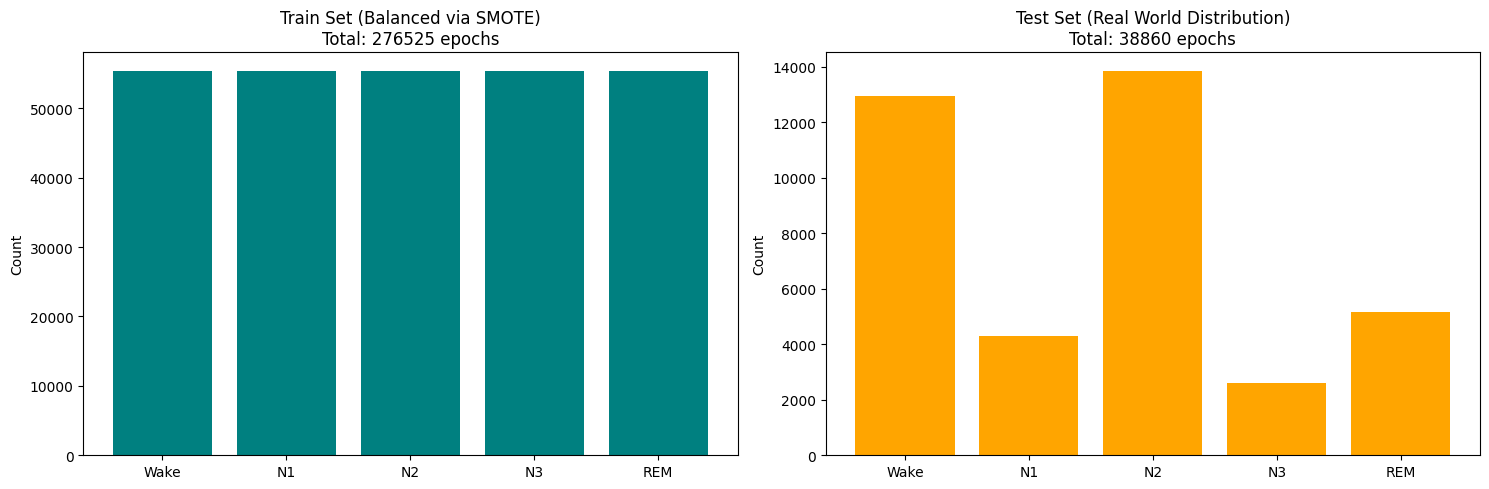

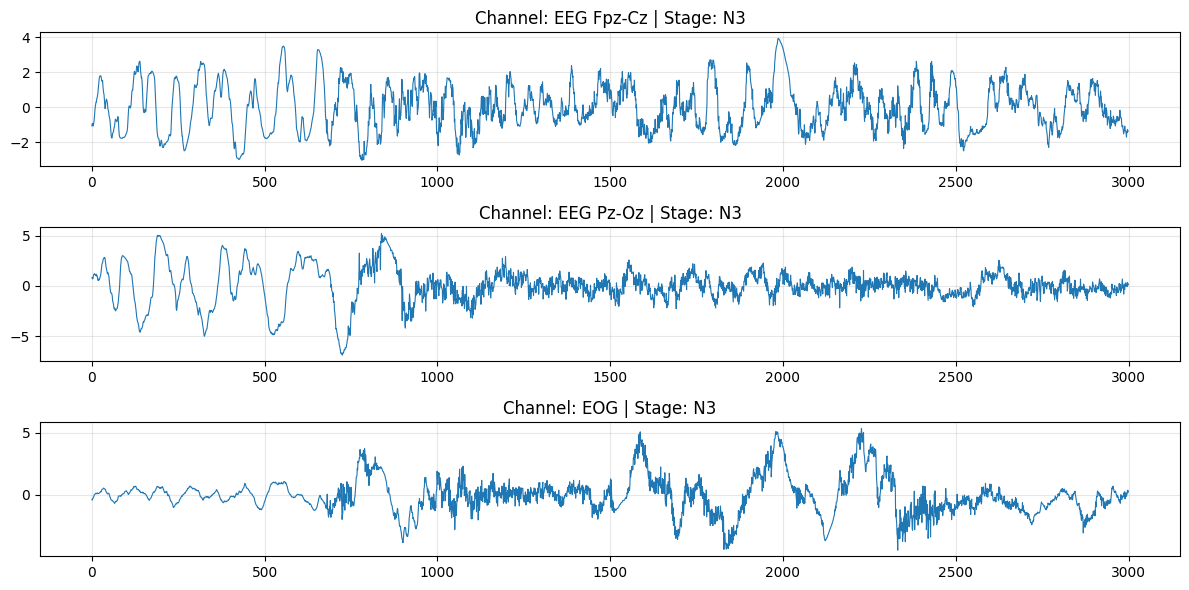

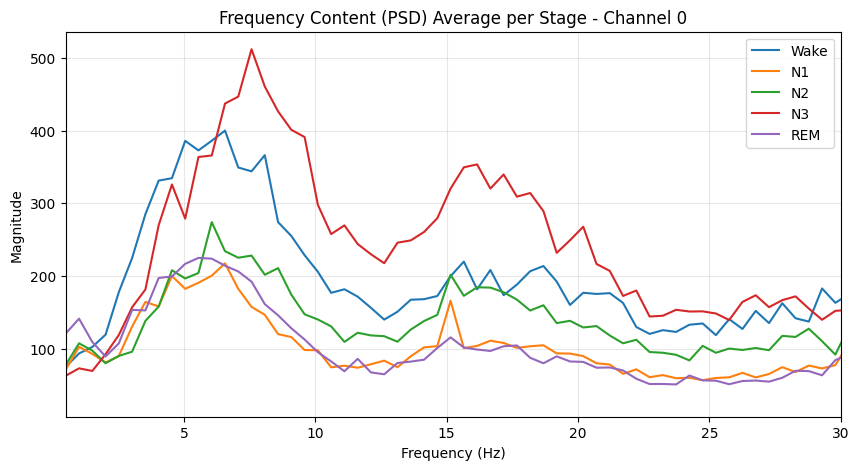

In [4]:
# ==========================================
# 1. Load processed datasets
# ==========================================

# Load training set (balanced using SMOTE)
train_data = np.load('train_smote_final.npz')

# Load test set (real-world distribution)
test_data = np.load('test_final.npz')

X_train, y_train = train_data['x'], train_data['y']
X_test, y_test = test_data['x'], test_data['y']

# Sleep stage names (numeric label → readable name)
stages = ['Wake', 'N1', 'N2', 'N3', 'REM']


# ---------------------------------------------------------
# Visualization 1: Class distribution (Train vs Test)
# ---------------------------------------------------------

# Count number of epochs per stage
train_counts = [Counter(y_train)[i] for i in range(5)]
test_counts = [Counter(y_test)[i] for i in range(5)]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Training set (balanced)
ax[0].bar(stages, train_counts, color='teal')
ax[0].set_title(f"Train Set (Balanced via SMOTE)\nTotal: {len(y_train)} epochs")
ax[0].set_ylabel("Count")

# Test set (natural distribution)
ax[1].bar(stages, test_counts, color='orange')
ax[1].set_title(f"Test Set (Real World Distribution)\nTotal: {len(y_test)} epochs")
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


# ---------------------------------------------------------
# Visualization 2: Example of a normalized epoch
# ---------------------------------------------------------

# Randomly select one epoch from the training set
sample_idx = np.random.randint(0, len(X_train))
sample_x = X_train[sample_idx]
sample_y = y_train[sample_idx]

plt.figure(figsize=(12, 6))

channels = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG']

# Plot each channel separately
for i in range(3):
    plt.subplot(3, 1, i + 1)
    
    # Plot normalized signal (30-second epoch)
    plt.plot(sample_x[:, i], lw=0.8)
    
    plt.title(f"Channel: {channels[i]} | Stage: {stages[sample_y]}")
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


# ---------------------------------------------------------
# Visualization 3: Average frequency content per stage (simple PSD)
# ---------------------------------------------------------

plt.figure(figsize=(10, 5))

for stage_idx in range(5):
    
    # Select up to 50 epochs from the current stage (for fast visualization)
    mask = y_train == stage_idx
    subset = X_train[mask][:50, :, 0]  # Use first EEG channel only
    
    # Compute simple FFT magnitude (approximate PSD)
    fft_vals = np.mean(
        np.abs(np.fft.fft(subset, axis=1))[:, :100],
        axis=0
    )
    
    # Frequency axis (assuming sampling rate ≈100 Hz → Nyquist = 50 Hz)
    freqs = np.linspace(0, 50, 100)
    
    plt.plot(freqs, fft_vals, label=stages[stage_idx])

plt.title("Frequency Content (PSD) Average per Stage - Channel 0")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()

# Most sleep-related EEG information lies below 30 Hz
plt.xlim(0.5, 30)
plt.grid(alpha=0.3)
plt.show()


### 📊 Statistical Justification for Multi-Channel Strategy (Feature Extraction & Hypothesis Testing)

Before designing our deep learning architecture, we must statistically validate the necessity of using all three available channels: Frontal EEG (**Fpz-Cz**), Occipital EEG (**Pz-Oz**), and **EOG**. 

In this section, we extract domain-specific physiological features from a random subset of our training data (2,000 epochs per relevant stage) and perform formal hypothesis testing:

#### 1. Feature Extraction 
* **Spectral Power (Welch's Method):** We compute the Power Spectral Density (PSD) using Welch's method to extract **Alpha band power (8-12 Hz)** and **Delta band power (0.5-4 Hz)** from both EEG channels.
* **Signal Variance:** We calculate the variance of the EOG channel as a quantitative proxy for rapid eye movement intensity.

#### 2. Statistical Testing (T-Tests)
We define the following alternative hypotheses ($H_1$) based on known sleep physiology:
* **Test 1 (Wakefulness):** A paired t-test to verify that Alpha power is significantly higher in the Occipital region compared to the Frontal region during Stage W.
* **Test 2 (Deep Sleep):** A paired t-test to verify that Delta power is significantly higher in the Frontal region compared to the Occipital region during Stage N3.
* **Test 3 (REM Sleep):** An independent t-test to verify that EOG variance is significantly higher during REM sleep compared to deep sleep (N3).

The code below executes these tests and visualizes the distributions. Exceptionally low $p$-values ($p < 0.05$) will firmly reject the null hypotheses, proving that each channel contributes unique, stage-critical information that our model must learn.

Loading data...
Calculating features (this might take a few seconds)...

=== P-Values ===
Alpha (Wake): p = 1.30e-91
Delta (N3): p = 5.83e-35
EOG (REM vs N3): p = 8.72e-60


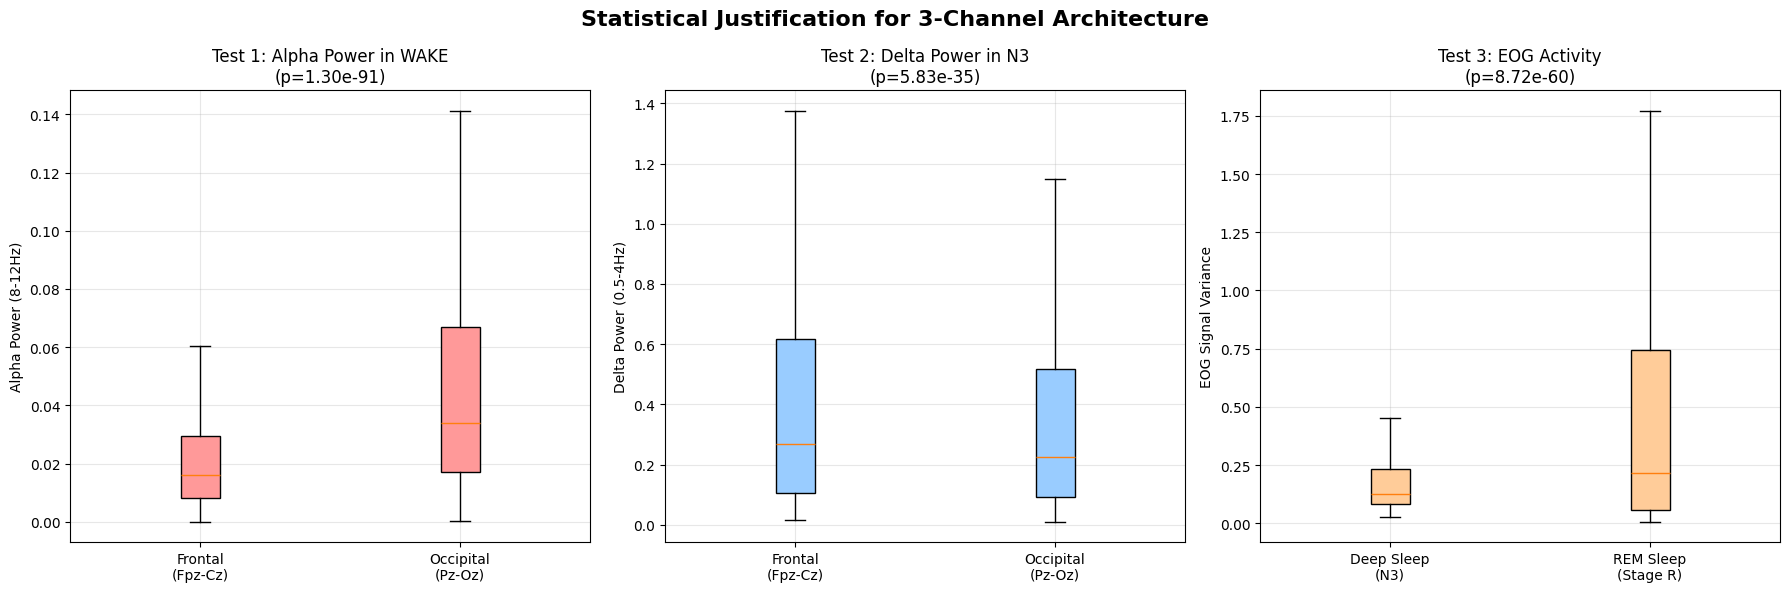

In [5]:
# ==========================================
# Load balanced training data
# ==========================================

print("Loading data...")
data = np.load('train_smote_final.npz')
X, y = data['x'], data['y']

# Sampling frequency (Hz)
SFREQ = 100 

# Channel indices (based on preprocessing order)
CH_FRONTAL = 0    # EEG Fpz-Cz
CH_OCCIPITAL = 1  # EEG Pz-Oz
CH_EOG = 2        # EOG horizontal


# ==========================================
# Feature extraction functions
# ==========================================

def get_band_power(epochs, channel_idx, fmin, fmax):
    """
    Compute band power using Welch's PSD estimate.
    
    Parameters:
        epochs: (N, Time, Channels)
        channel_idx: channel to analyze
        fmin, fmax: frequency band (Hz)
        
    Returns:
        Array of band power values per epoch
    """
    powers = []
    
    # IMPORTANT: Data shape is (epochs, time, channels)
    channel_data = epochs[:, :, channel_idx] 
    
    for epoch in channel_data:
        freqs, psd = welch(epoch, SFREQ, nperseg=256)
        
        # Select frequency band
        idx_band = np.logical_and(freqs >= fmin, freqs <= fmax)
        
        # Integrate PSD over band (area under curve)
        power = np.trapz(psd[idx_band], freqs[idx_band])
        powers.append(power)
        
    return np.array(powers)


def get_signal_variance(epochs, channel_idx):
    """
    Compute signal variance over time (per epoch).
    Used as a simple proxy for EOG activity.
    """
    # Variance across time axis (axis=1)
    return np.var(epochs[:, :, channel_idx], axis=1)


# ==========================================
# Random sampling (balanced comparison)
# ==========================================

np.random.seed(42)

# Randomly sample 2000 epochs per stage
wake_idx = np.random.choice(np.where(y == 0)[0], 2000, replace=False)
n3_idx = np.random.choice(np.where(y == 3)[0], 2000, replace=False)
rem_idx = np.random.choice(np.where(y == 4)[0], 2000, replace=False)

wake_epochs = X[wake_idx]
n3_epochs = X[n3_idx]
rem_epochs = X[rem_idx]

print("Calculating features (this might take a few seconds)...")

# ==========================================
# Hypothesis-driven feature extraction
# ==========================================

# 1. Alpha power (8–12 Hz) during WAKE
alpha_frontal = get_band_power(wake_epochs, CH_FRONTAL, 8, 12)
alpha_occipital = get_band_power(wake_epochs, CH_OCCIPITAL, 8, 12)

# 2. Delta power (0.5–4 Hz) during N3 (Deep Sleep)
delta_frontal = get_band_power(n3_epochs, CH_FRONTAL, 0.5, 4)
delta_occipital = get_band_power(n3_epochs, CH_OCCIPITAL, 0.5, 4)

# 3. Eye movement activity (variance of EOG signal)
eog_rem = get_signal_variance(rem_epochs, CH_EOG)
eog_n3 = get_signal_variance(n3_epochs, CH_EOG)


# ==========================================
# Statistical hypothesis testing
# ==========================================

# Test 1: Occipital alpha > Frontal alpha during WAKE (paired test)
t_stat_alpha, p_val_alpha = stats.ttest_rel(
    alpha_occipital,
    alpha_frontal,
    alternative='greater'
)

# Test 2: Frontal delta > Occipital delta during N3 (paired test)
t_stat_delta, p_val_delta = stats.ttest_rel(
    delta_frontal,
    delta_occipital,
    alternative='greater'
)

# Test 3: REM EOG variance > N3 EOG variance (independent test)
t_stat_eog, p_val_eog = stats.ttest_ind(
    eog_rem,
    eog_n3,
    equal_var=False,
    alternative='greater'
)

print("\n=== P-Values ===")
print(f"Alpha (Wake): p = {p_val_alpha:.2e}")
print(f"Delta (N3): p = {p_val_delta:.2e}")
print(f"EOG (REM vs N3): p = {p_val_eog:.2e}")


# ==========================================
# Visualization
# ==========================================

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# --- Alpha comparison ---
ax1.boxplot(
    [alpha_frontal, alpha_occipital],
    tick_labels=['Frontal\n(Fpz-Cz)', 'Occipital\n(Pz-Oz)'],
    patch_artist=True,
    boxprops=dict(facecolor='#ff9999'),
    showfliers=False
)
ax1.set_title(f"Test 1: Alpha Power in WAKE\n(p={p_val_alpha:.2e})")
ax1.set_ylabel("Alpha Power (8-12Hz)")
ax1.grid(alpha=0.3)

# --- Delta comparison ---
ax2.boxplot(
    [delta_frontal, delta_occipital],
    tick_labels=['Frontal\n(Fpz-Cz)', 'Occipital\n(Pz-Oz)'],
    patch_artist=True,
    boxprops=dict(facecolor='#99ccff'),
    showfliers=False
)
ax2.set_title(f"Test 2: Delta Power in N3\n(p={p_val_delta:.2e})")
ax2.set_ylabel("Delta Power (0.5-4Hz)")
ax2.grid(alpha=0.3)

# --- EOG comparison ---
ax3.boxplot(
    [eog_n3, eog_rem],
    tick_labels=['Deep Sleep\n(N3)', 'REM Sleep\n(Stage R)'],
    patch_artist=True,
    boxprops=dict(facecolor='#ffcc99'),
    showfliers=False
)
ax3.set_title(f"Test 3: EOG Activity\n(p={p_val_eog:.2e})")
ax3.set_ylabel("EOG Signal Variance")
ax3.grid(alpha=0.3)

plt.suptitle(
    "Statistical Justification for 3-Channel Architecture",
    fontsize=16,
    fontweight='bold'
)

plt.tight_layout()
plt.show()


### 🔄 Part 3: Sleep Architecture & Transition Dynamics (Markov Chain)

Sleep is not a random sequence of events; it follows a highly structured biological cycle known as "Sleep Architecture." A healthy individual typically progresses smoothly through the sleep stages (e.g., Wake $\rightarrow$ N1 $\rightarrow$ N2 $\rightarrow$ N3) and rarely jumps abruptly from Deep Sleep (N3) directly to Wakefulness.

To explore this temporal dependency within our dataset, we construct a **Transition Probability Matrix (Markov Chain)**. This matrix calculates the empirical probability $P(S_{t+1} | S_t)$, representing the likelihood of transitioning to a specific sleep stage in the next 30-second epoch, given the current stage.

Understanding these dynamics is critical for our Deep Learning approach: it justifies our decision to use a **Bidirectional GRU (Bi-GRU)** in our model architecture, which is explicitly designed to learn these temporal sequential rules.

Calculating transition dynamics from raw sequences...


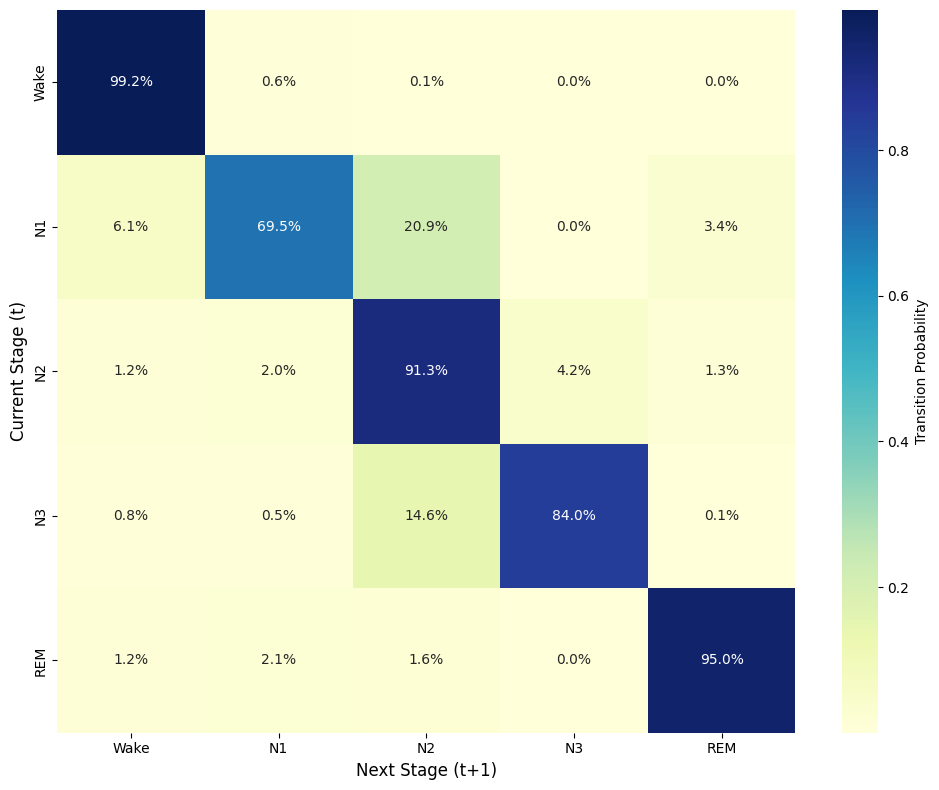

In [7]:
# ==========================================================
# Sleep Stage Transition Dynamics Analysis
# ==========================================================

# Mapping original EDF annotation labels to our 5-stage scheme
# Note: Sleep stages 3 and 4 are merged into N3 (deep sleep)
stage_mapping = {
    'Sleep stage W': 0, 'Sleep stage 1': 1, 'Sleep stage 2': 2,
    'Sleep stage 3': 3, 'Sleep stage 4': 3, 'Sleep stage R': 4
}

# Human-readable labels for visualization
labels = ['Wake', 'N1', 'N2', 'N3', 'REM']

# Path to raw Sleep-EDF dataset
RAW_FOLDER = 'sleep-edf-database-expanded-1.0.0'

# Collect all hypnogram annotation files recursively
hypno_files = sorted(glob.glob(os.path.join(RAW_FOLDER, '**', '*Hypnogram.edf'), recursive=True))

# Initialize transition count matrix (5x5 for 5 sleep stages)
# Entry (i, j) will count transitions from stage i → stage j
transition_counts = np.zeros((5, 5))

print("Calculating transition dynamics from raw sequences...")

# We process a subset of nights (first 50) for faster computation.
# This provides a representative yet computationally efficient estimate.
for hypno_p in hypno_files[:50]: 
    try:
        # Read annotation file using MNE
        annot = mne.read_annotations(hypno_p)
        
        # This list will store the chronological stage sequence
        seq = []
        
        # Construct the exact temporal sequence of sleep stages
        # Each annotation has a duration (in seconds)
        for desc, duration in zip(annot.description, annot.duration):
            if desc in stage_mapping:
                stage = stage_mapping[desc]
                
                # Convert duration into standard 30-second epochs
                n_epochs = int(duration / 30)
                
                # Extend the sequence with repeated stage labels
                seq.extend([stage] * n_epochs)
        
        # Count first-order transitions: S_t → S_{t+1}
        for i in range(len(seq) - 1):
            curr_stage = seq[i]
            next_stage = seq[i+1]
            transition_counts[curr_stage, next_stage] += 1
            
    except Exception as e:
        # Skip corrupted or unreadable files
        continue


# ==========================================================
# Convert Counts to Transition Probabilities
# ==========================================================

# Compute row sums (total outgoing transitions from each stage)
row_sums = transition_counts.sum(axis=1, keepdims=True)

# Normalize rows to obtain conditional probabilities:
# P(Stage_{t+1} | Stage_t)
transition_probs = np.divide(
    transition_counts,
    row_sums,
    out=np.zeros_like(transition_counts),
    where=row_sums != 0
)


# ==========================================================
# Visualization: Markov Transition Matrix Heatmap
# ==========================================================

plt.figure(figsize=(10, 8))

# Heatmap shows conditional transition probabilities
# Each row represents the current stage (t)
# Each column represents the next stage (t+1)
sns.heatmap(
    transition_probs,
    annot=True,
    fmt=".1%",
    cmap="YlGnBu",
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws={'label': 'Transition Probability'}
)


plt.xlabel("Next Stage (t+1)", fontsize=12)
plt.ylabel("Current Stage (t)", fontsize=12)

plt.tight_layout()
plt.show()
